In [1]:
import sys
sys.path.append('..')

import pandas as pd
import matplotlib.pyplot as plt
import pandas_gbq as pbq
import numpy as np
from noaa.ghcnd import NOAAStore
from extremevalue.gpd import GPDMLE

In [2]:
store = NOAAStore()

In [76]:
stations = store.stations()

In [3]:
prcp = store.timeseries_universe(element='PRCP')

In [4]:
def coverage(s):
    start = s.index.get_level_values('date').min()
    end = s.index.get_level_values('date').max()
    count = s.count()
    length = (end-start).days+1
    coverage = count/length
    return {'start':start,'end':end,'coverage':coverage}
    

In [5]:
prcp_stats = pd.DataFrame(prcp.groupby('id').apply(coverage)).unstack(1)['value'].sort_values('coverage')
prcp_stats

,start,end,coverage
id,,,
USC00270390,1903-09-01,2022-04-30,0.043699
USC00478515,1936-11-01,2022-10-25,0.049769
USC00486875,1948-08-01,2022-10-31,0.05826
USC00042084,1914-01-01,2022-06-04,0.062497
USC00476854,1948-08-01,2022-11-30,0.066041
...,...,...,...
USW00024127,1948-01-01,2022-12-18,0.99989
USW00003822,1948-01-01,2022-12-18,0.99989
USW00023047,1947-01-01,2022-12-18,0.999892


In [147]:
def returnlevel_stats(ts):
    start = ts.index.get_level_values('date').min()
    end = ts.index.get_level_values('date').max()
    count = ts.count()
    length = (end-start).days+1
    coverage = count/length
    
    rl = {
        '10y'     : np.nan,
        '10y_se'  : np.nan,
        '100y'    : np.nan,
        '100y_se' : np.nan,
        'xi'      : np.nan,
        'sigma'   : np.nan,
    }
    
    if (count < 10000) | (coverage < 0.85):
        return rl
    
    
    u = ts.quantile(0.99)
    gpd = GPDMLE(u)
    gpd.fit(ts.values)

    period_1y = 365.25

    params = gpd.get_params()

    rl['10y'] =  gpd.return_level(10.0, period=period_1y)
    rl['10y_se'] =  gpd.return_level_se(10.0, period=period_1y)
    rl['100y'] =  gpd.return_level(100.0, period=period_1y)
    rl['100y_se'] =  gpd.return_level_se(100.0, period=period_1y)
    rl['xi'] = params['xi']
    rl['sigma'] = params['sigma']
    rl['mu'] = u

    return rl

In [148]:
prcp_filtered = prcp.loc[lambda x: (x>=0.0) & (x<1500.0)].copy() #simple cleaning for now

In [149]:
prcp_rl = prcp_filtered.groupby('id').apply(returnlevel_stats).unstack(1).dropna()

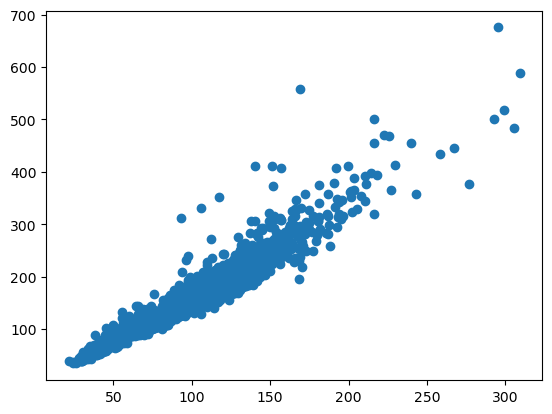

In [150]:
plt.scatter(prcp_rl['10y'],prcp_rl['100y'])

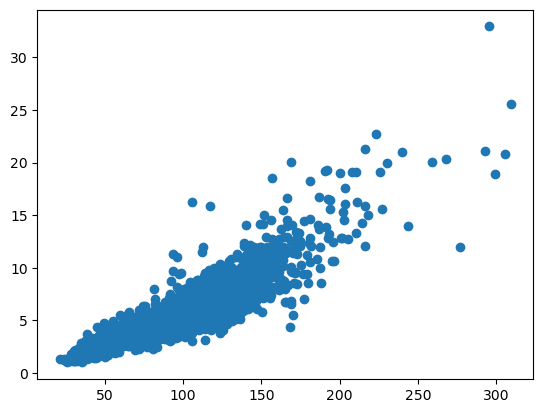

In [166]:
plt.scatter(prcp_rl['10y'],prcp_rl['10y_se'])

In [162]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [169]:
prcp_l48 = prcp_rl[['10y','10y_se']].join(stations).loc[lambda df: ~df['state'].isin(['AK','HI'])]

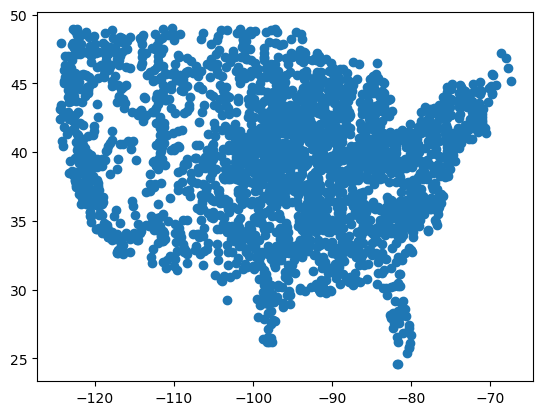

In [220]:
x = prcp_l48['longitude'].values
y = prcp_l48['latitude'].values
z = prcp_l48['10y'].astype('float')
z_var = np.power(prcp_l48['10y_se'].astype('float').values,2.0)

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

plt.scatter(x,y)

In [221]:
X = np.array([x,y]).T
X.shape

(2399, 2)

In [245]:


kernel = 1.0 * RBF(length_scale=(1e1,1e1), length_scale_bounds=(1e0, 1e2))
# kernel +=   WhiteKernel( noise_level=1e-1, noise_level_bounds=(1e-2, 1e1))

gpr = GaussianProcessRegressor(kernel=kernel, alpha=z_var,  n_restarts_optimizer=2, normalize_y=True)


In [246]:
gpr.fit(X,z)

GaussianProcessRegressor(alpha=array([364.60470861,  54.49613217,  43.67260174, ...,  20.17197197,
        58.77334761,  26.98720471]),
                         kernel=1**2 * RBF(length_scale=[10, 10]),
                         n_restarts_optimizer=2, normalize_y=True)

In [247]:
print('fit', gpr.kernel_)

fit 0.92**2 * RBF(length_scale=[11, 14.6])


In [248]:
y_mean, y_std = gpr.predict(X, return_std=True)

In [249]:
y_mean

array([128.61541873, 116.86619745, 113.69391692, ...,  88.82457749,
       100.17100598,  86.20638987])

In [250]:
y_std

array([12.59276266,  9.47301532,  8.85592492, ...,  7.06722226,
        6.95721883,  9.59601486])

In [251]:
np.sqrt(z_var)

array([19.09462512,  7.38214956,  6.60852493, ...,  4.49132185,
        7.66637774,  5.19492105])

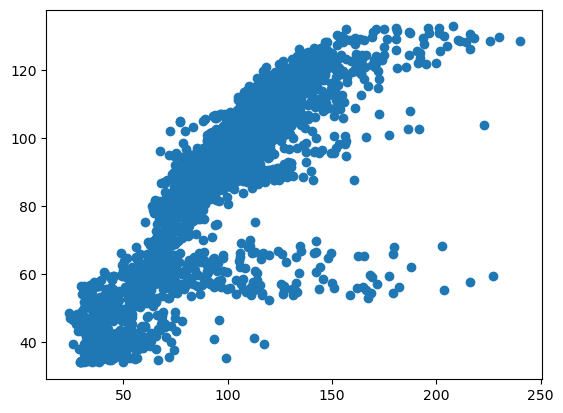

In [252]:
plt.scatter(z,y_mean)

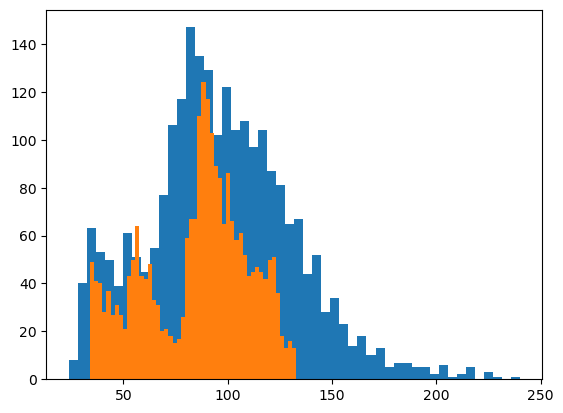

In [257]:
plt.hist(z,50);
plt.hist(y_mean,50);

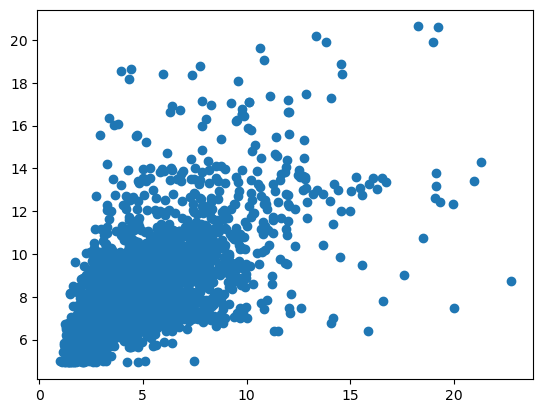

In [259]:
plt.scatter(np.sqrt(z_var),y_std)